In [173]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [192]:
# Create Tensors to hold input and outputs.
beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0.5
prior=7

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [193]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


tensor(0.2181, dtype=torch.float64)

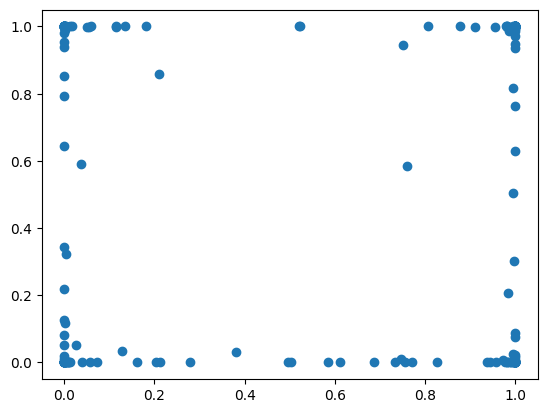

In [194]:
plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x3@beta_3).squeeze().cov()

In [195]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [196]:
################## first step##################

# choose lambda1,lambda2 by ray tune

prior=7
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2 = config["lambda1"], config["lambda2"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=0.9
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.0005,0.001,0.002])
    }
    result = tune.run(
        train_model,  
        config=config,
        num_samples=20)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,lambda1,lambda2,iter,total time (s),my_test_BCE_loss
train_model_33d01_00000,TERMINATED,10.224.0.12:22696,0.05,0.002,1,8.11428,1.29891
train_model_33d01_00001,TERMINATED,10.224.0.12:23037,0.03,0.0005,1,8.07408,1.54992
train_model_33d01_00002,TERMINATED,10.224.0.12:23040,0.05,0.0005,1,7.44538,1.55267
train_model_33d01_00003,TERMINATED,10.224.0.12:23042,0.04,0.001,1,7.29411,1.44351
train_model_33d01_00004,TERMINATED,10.224.0.12:23044,0.05,0.002,1,9.51635,1.29891
train_model_33d01_00005,TERMINATED,10.224.0.12:23043,0.04,0.0005,1,9.31414,1.53211
train_model_33d01_00006,TERMINATED,10.224.0.12:23048,0.05,0.002,1,9.58109,1.29891
train_model_33d01_00007,TERMINATED,10.224.0.12:23047,0.05,0.001,1,7.54451,1.44895
train_model_33d01_00008,TERMINATED,10.224.0.12:23051,0.05,0.0005,1,9.11302,1.55267
train_model_33d01_00009,TERMINATED,10.224.0.12:23052,0.03,0.001,1,7.7582,1.4529


Result for train_model_33d01_00000:
  date: 2022-10-17_21-04-25
  done: false
  experiment_id: dd42d5604e584da18ea4563eaa234237
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2989066123962403
  node_ip: 10.224.0.12
  pid: 22696
  time_since_restore: 8.11427903175354
  time_this_iter_s: 8.11427903175354
  time_total_s: 8.11427903175354
  timestamp: 1666011865
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 33d01_00000
  warmup_time: 0.003645181655883789
  
Result for train_model_33d01_00000:
  date: 2022-10-17_21-04-25
  done: true
  experiment_id: dd42d5604e584da18ea4563eaa234237
  experiment_tag: 0_lambda1=0.0500,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2989066123962403
  node_ip: 10.224.0.12
  pid: 22696
  time_since_restore: 8.11427903175354
  time_this_iter_s: 8.11427903175354
  time_total_s: 8.11427903175354
  timestamp: 1666011865
  timesteps_since_restore: 0
  training

Result for train_model_33d01_00001:
  date: 2022-10-17_21-04-28
  done: false
  experiment_id: 544ab189ef6744a2ab917fd1dda549d9
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5499247550964355
  node_ip: 10.224.0.12
  pid: 23037
  time_since_restore: 8.07407546043396
  time_this_iter_s: 8.07407546043396
  time_total_s: 8.07407546043396
  timestamp: 1666011868
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 33d01_00001
  warmup_time: 0.0038225650787353516
  
Result for train_model_33d01_00001:
  date: 2022-10-17_21-04-28
  done: true
  experiment_id: 544ab189ef6744a2ab917fd1dda549d9
  experiment_tag: 1_lambda1=0.0300,lambda2=0.0005
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5499247550964355
  node_ip: 10.224.0.12
  pid: 23037
  time_since_restore: 8.07407546043396
  time_this_iter_s: 8.07407546043396
  time_total_s: 8.07407546043396
  timestamp: 1666011868
  timesteps_since_restore: 0
  trainin

Result for train_model_33d01_00005:
  date: 2022-10-17_21-04-30
  done: false
  experiment_id: 379d11a4dc3b4019a847136599994a09
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5321117401123048
  node_ip: 10.224.0.12
  pid: 23043
  time_since_restore: 9.314138412475586
  time_this_iter_s: 9.314138412475586
  time_total_s: 9.314138412475586
  timestamp: 1666011870
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 33d01_00005
  warmup_time: 0.0036988258361816406
  
Result for train_model_33d01_00005:
  date: 2022-10-17_21-04-30
  done: true
  experiment_id: 379d11a4dc3b4019a847136599994a09
  experiment_tag: 5_lambda1=0.0400,lambda2=0.0005
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5321117401123048
  node_ip: 10.224.0.12
  pid: 23043
  time_since_restore: 9.314138412475586
  time_this_iter_s: 9.314138412475586
  time_total_s: 9.314138412475586
  timestamp: 1666011870
  timesteps_since_restore: 0
  t

2022-10-17 21:04:30,397	INFO tune.py:758 -- Total run time: 15.04 seconds (14.85 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
33d01_00000          1.298907          8.114279  True            None   
33d01_00001          1.549925          8.074075  True            None   
33d01_00002          1.552673          7.445376  True            None   
33d01_00003          1.443507          7.294108  True            None   
33d01_00004          1.298907          9.516346  True            None   
33d01_00005          1.532112          9.314138  True            None   
33d01_00006          1.298907          9.581091  True            None   
33d01_00007          1.448951          7.544510  True            None   
33d01_00008          1.552673          9.113024  True            None   
33d01_00009          1.452899          7.758204  True            None   
33d01_00010          1.549925          8.232152  True            N

In [197]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.2982225179672242


{'lambda1': 0.03, 'lambda2': 0.002}

In [198]:
################## second step##################

#0.4,0.4
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2=final_lambda["lambda1"],final_lambda["lambda2"]
learning_rate=0.9
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.0860, grad_fn=<AddBackward0>)

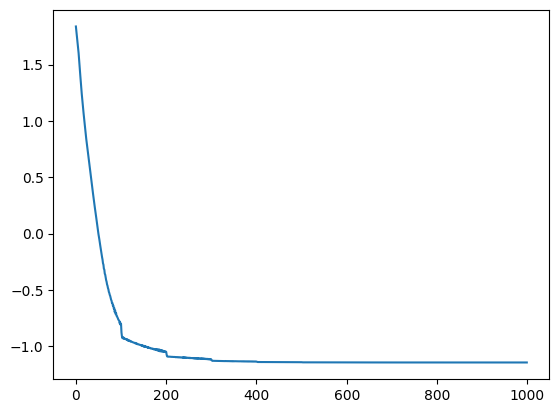

In [199]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [200]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x3)[0]).detach().squeeze()

BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss
BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(0.0860)

tensor(0.0367)

tensor(0.0078)

tensor(0.0414)

In [201]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[90,  0],
       [ 0, 70]])

array([[88,  0],
       [ 0, 72]])

array([[69,  0],
       [ 0, 91]])

In [ ]:
################## third step##################

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta = config["lambda1"], config["lambda2"],config["eta"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    sum_tGM=0
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=0.9
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
# #         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
# #         test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
# #         test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))

#         test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
#         test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
#         sum_test_BCE_loss+=test_BCE_loss.item()

#     #print("loss: ",)
#     tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)

        test_prediction_1= (model_1(train_x1[idx_test])[0]>0.5).clone().int()
        test_target_1= train_y1[idx_test].reshape(-1,1).int()

        test_prediction_2= (model_2(train_x2[idx_test])[0]>0.5).clone().int()
        test_target_2= train_y2[idx_test].reshape(-1,1).int()

        test_prediction_3= (model_3(train_x3[idx_test])[0]>0.5).clone().int()
        test_target_3= train_y3[idx_test].reshape(-1,1).int()

        test_prediction=np.append(test_prediction_1,test_prediction_2)
        test_prediction=np.append(test_prediction,test_prediction_3)
        test_prediction=test_prediction.tolist()

        test_target=np.append(test_target_1,test_target_2)
        test_target=np.append(test_target,test_target_3)
        test_target=test_target.tolist()

        final_matrix=confusion_matrix(test_target,test_prediction)
        tTPR=recall_score(test_target,test_target)#TPR
        tTNR=final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
        tGM=math.sqrt(tTPR*tTNR)

        sum_tGM+=tGM

    tune.report(my_test_sum_tGM=sum_tGM/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
#     config={
#         "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
#         "lambda2": tune.choice([0.001,0.002,0.003]),
#         "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
#     }
    config={
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.002,0.003,0.001]),
        "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
    }


    result = tune.run(
        train_model,  
        config=config,
        num_samples=160)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2,iter,total time (s),my_test_sum_tGM
train_model_b890c_00105,RUNNING,10.224.0.12:27685,0.6,0.03,0.003,,,
train_model_b890c_00106,RUNNING,10.224.0.12:27742,0.8,0.04,0.002,1,14.4703,0.935151
train_model_b890c_00107,RUNNING,10.224.0.12:27748,0.6,0.03,0.002,,,
train_model_b890c_00108,RUNNING,10.224.0.12:27762,0.3,0.05,0.001,,,
train_model_b890c_00109,RUNNING,10.224.0.12:27704,0.3,0.04,0.002,,,
train_model_b890c_00110,RUNNING,10.224.0.12:27706,0.3,0.05,0.001,,,
train_model_b890c_00111,RUNNING,10.224.0.12:27749,0.6,0.04,0.003,,,
train_model_b890c_00137,PENDING,,0.1,0.05,0.002,,,
train_model_b890c_00138,PENDING,,0.4,0.05,0.001,,,
train_model_b890c_00139,PENDING,,0.3,0.03,0.002,,,


Result for train_model_b890c_00000:
  date: 2022-10-17_21-08-15
  done: false
  experiment_id: eaa9776b76c94f6c9a9b221ac4f6aab7
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9132474851990905
  node_ip: 10.224.0.12
  pid: 27139
  time_since_restore: 14.429150581359863
  time_this_iter_s: 14.429150581359863
  time_total_s: 14.429150581359863
  timestamp: 1666012095
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b890c_00000
  warmup_time: 0.0037500858306884766
  
Result for train_model_b890c_00000:
  date: 2022-10-17_21-08-15
  done: true
  experiment_id: eaa9776b76c94f6c9a9b221ac4f6aab7
  experiment_tag: 0_eta=0.2000,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9132474851990905
  node_ip: 10.224.0.12
  pid: 27139
  time_since_restore: 14.429150581359863
  time_this_iter_s: 14.429150581359863
  time_total_s: 14.429150581359863
  timestamp: 1666012095
  timesteps_since

Result for train_model_b890c_00006:
  date: 2022-10-17_21-08-19
  done: false
  experiment_id: 3e7d81ddf9f84e64a2e04cafd49ae2e2
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9439707562841576
  node_ip: 10.224.0.12
  pid: 27686
  time_since_restore: 14.757549047470093
  time_this_iter_s: 14.757549047470093
  time_total_s: 14.757549047470093
  timestamp: 1666012099
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b890c_00006
  warmup_time: 0.006632804870605469
  
Result for train_model_b890c_00006:
  date: 2022-10-17_21-08-19
  done: true
  experiment_id: 3e7d81ddf9f84e64a2e04cafd49ae2e2
  experiment_tag: 6_eta=0.9000,lambda1=0.0500,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9439707562841576
  node_ip: 10.224.0.12
  pid: 27686
  time_since_restore: 14.757549047470093
  time_this_iter_s: 14.757549047470093
  time_total_s: 14.757549047470093
  timestamp: 1666012099
  timesteps_since_

Result for train_model_b890c_00015:
  date: 2022-10-17_21-08-19
  done: true
  experiment_id: 943744750dcd46e58f6b26108609cba4
  experiment_tag: 15_eta=0.3000,lambda1=0.0500,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9352014996159849
  node_ip: 10.224.0.12
  pid: 27706
  time_since_restore: 15.401429414749146
  time_this_iter_s: 15.401429414749146
  time_total_s: 15.401429414749146
  timestamp: 1666012099
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b890c_00015
  warmup_time: 0.010809898376464844
  
Result for train_model_b890c_00022:
  date: 2022-10-17_21-08-19
  done: false
  experiment_id: b96a85a12b9c415a83363a53362c8443
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9043482397422906
  node_ip: 10.224.0.12
  pid: 27745
  time_since_restore: 14.518453121185303
  time_this_iter_s: 14.518453121185303
  time_total_s: 14.518453121185303
  timestamp: 1666012099
  timesteps_since

Result for train_model_b890c_00030:
  date: 2022-10-17_21-08-20
  done: false
  experiment_id: 43cb52ffd0954e0c836bdc74c9b0edc6
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8952175279473542
  node_ip: 10.224.0.12
  pid: 27761
  time_since_restore: 15.416816711425781
  time_this_iter_s: 15.416816711425781
  time_total_s: 15.416816711425781
  timestamp: 1666012100
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b890c_00030
  warmup_time: 0.0072710514068603516
  
Result for train_model_b890c_00030:
  date: 2022-10-17_21-08-20
  done: true
  experiment_id: 43cb52ffd0954e0c836bdc74c9b0edc6
  experiment_tag: 30_eta=0.3000,lambda1=0.0300,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8952175279473542
  node_ip: 10.224.0.12
  pid: 27761
  time_since_restore: 15.416816711425781
  time_this_iter_s: 15.416816711425781
  time_total_s: 15.416816711425781
  timestamp: 1666012100
  timesteps_sinc

Result for train_model_b890c_00032:
  date: 2022-10-17_21-08-29
  done: false
  experiment_id: eaa9776b76c94f6c9a9b221ac4f6aab7
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9111458606026421
  node_ip: 10.224.0.12
  pid: 27139
  time_since_restore: 14.24337124824524
  time_this_iter_s: 14.24337124824524
  time_total_s: 14.24337124824524
  timestamp: 1666012109
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b890c_00032
  warmup_time: 0.0037500858306884766
  
Result for train_model_b890c_00032:
  date: 2022-10-17_21-08-29
  done: true
  experiment_id: eaa9776b76c94f6c9a9b221ac4f6aab7
  experiment_tag: 32_eta=0.6000,lambda1=0.0300,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9111458606026421
  node_ip: 10.224.0.12
  pid: 27139
  time_since_restore: 14.24337124824524
  time_this_iter_s: 14.24337124824524
  time_total_s: 14.24337124824524
  timestamp: 1666012109
  timesteps_since_rest

Result for train_model_b890c_00043:
  date: 2022-10-17_21-08-33
  done: false
  experiment_id: 057442cb777c440fb03f48305983d753
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9222177010186858
  node_ip: 10.224.0.12
  pid: 27685
  time_since_restore: 14.153919458389282
  time_this_iter_s: 14.153919458389282
  time_total_s: 14.153919458389282
  timestamp: 1666012113
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b890c_00043
  warmup_time: 0.008030891418457031
  
Result for train_model_b890c_00043:
  date: 2022-10-17_21-08-33
  done: true
  experiment_id: 057442cb777c440fb03f48305983d753
  experiment_tag: 43_eta=0.1000,lambda1=0.0500,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9222177010186858
  node_ip: 10.224.0.12
  pid: 27685
  time_since_restore: 14.153919458389282
  time_this_iter_s: 14.153919458389282
  time_total_s: 14.153919458389282
  timestamp: 1666012113
  timesteps_since

Result for train_model_b890c_00045:
  date: 2022-10-17_21-08-35
  done: false
  experiment_id: b19cedf5299440b5b49897439081f937
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9289264318167788
  node_ip: 10.224.0.12
  pid: 27691
  time_since_restore: 15.752930164337158
  time_this_iter_s: 15.752930164337158
  time_total_s: 15.752930164337158
  timestamp: 1666012115
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b890c_00045
  warmup_time: 0.010373353958129883
  
Result for train_model_b890c_00045:
  date: 2022-10-17_21-08-35
  done: true
  experiment_id: b19cedf5299440b5b49897439081f937
  experiment_tag: 45_eta=0.2000,lambda1=0.0500,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9289264318167788
  node_ip: 10.224.0.12
  pid: 27691
  time_since_restore: 15.752930164337158
  time_this_iter_s: 15.752930164337158
  time_total_s: 15.752930164337158
  timestamp: 1666012115
  timesteps_since

Result for train_model_b890c_00062:
  date: 2022-10-17_21-08-36
  done: false
  experiment_id: 068cc7f3ee11430f976a97525f1e4bda
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9289484501461915
  node_ip: 10.224.0.12
  pid: 27751
  time_since_restore: 14.973315954208374
  time_this_iter_s: 14.973315954208374
  time_total_s: 14.973315954208374
  timestamp: 1666012116
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b890c_00062
  warmup_time: 0.004927873611450195
  
Result for train_model_b890c_00062:
  date: 2022-10-17_21-08-36
  done: true
  experiment_id: 068cc7f3ee11430f976a97525f1e4bda
  experiment_tag: 62_eta=0.7000,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9289484501461915
  node_ip: 10.224.0.12
  pid: 27751
  time_since_restore: 14.973315954208374
  time_this_iter_s: 14.973315954208374
  time_total_s: 14.973315954208374
  timestamp: 1666012116
  timesteps_since

Result for train_model_b890c_00068:
  date: 2022-10-17_21-08-47
  done: false
  experiment_id: e9e1ed6d0db24a5da07eab7fddce0215
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9224331740510173
  node_ip: 10.224.0.12
  pid: 27694
  time_since_restore: 14.39023494720459
  time_this_iter_s: 14.39023494720459
  time_total_s: 14.39023494720459
  timestamp: 1666012127
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b890c_00068
  warmup_time: 0.006027698516845703
  
Result for train_model_b890c_00068:
  date: 2022-10-17_21-08-47
  done: true
  experiment_id: e9e1ed6d0db24a5da07eab7fddce0215
  experiment_tag: 68_eta=0.3000,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9224331740510173
  node_ip: 10.224.0.12
  pid: 27694
  time_since_restore: 14.39023494720459
  time_this_iter_s: 14.39023494720459
  time_total_s: 14.39023494720459
  timestamp: 1666012127
  timesteps_since_resto

Result for train_model_b890c_00076:
  date: 2022-10-17_21-08-48
  done: false
  experiment_id: 2eae8495d7a24a1c952647d938adc147
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9223452236611271
  node_ip: 10.224.0.12
  pid: 27748
  time_since_restore: 14.410120964050293
  time_this_iter_s: 14.410120964050293
  time_total_s: 14.410120964050293
  timestamp: 1666012128
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b890c_00076
  warmup_time: 0.011415719985961914
  
Result for train_model_b890c_00076:
  date: 2022-10-17_21-08-48
  done: true
  experiment_id: 2eae8495d7a24a1c952647d938adc147
  experiment_tag: 76_eta=0.3000,lambda1=0.0400,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9223452236611271
  node_ip: 10.224.0.12
  pid: 27748
  time_since_restore: 14.410120964050293
  time_this_iter_s: 14.410120964050293
  time_total_s: 14.410120964050293
  timestamp: 1666012128
  timesteps_since

Result for train_model_b890c_00088:
  date: 2022-10-17_21-08-50
  done: false
  experiment_id: 2817310501d640e9acdbdae7b8d0e75f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9063491391468477
  node_ip: 10.224.0.12
  pid: 27723
  time_since_restore: 14.517505168914795
  time_this_iter_s: 14.517505168914795
  time_total_s: 14.517505168914795
  timestamp: 1666012130
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b890c_00088
  warmup_time: 0.006242275238037109
  
Result for train_model_b890c_00088:
  date: 2022-10-17_21-08-50
  done: true
  experiment_id: 2817310501d640e9acdbdae7b8d0e75f
  experiment_tag: 88_eta=0.5000,lambda1=0.0300,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9063491391468477
  node_ip: 10.224.0.12
  pid: 27723
  time_since_restore: 14.517505168914795
  time_this_iter_s: 14.517505168914795
  time_total_s: 14.517505168914795
  timestamp: 1666012130
  timesteps_since

Result for train_model_b890c_00092:
  date: 2022-10-17_21-08-52
  done: false
  experiment_id: 3d5a634dd738410ba96147f074ea551e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9245077970681465
  node_ip: 10.224.0.12
  pid: 27752
  time_since_restore: 15.683754444122314
  time_this_iter_s: 15.683754444122314
  time_total_s: 15.683754444122314
  timestamp: 1666012132
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b890c_00092
  warmup_time: 0.00877833366394043
  
Result for train_model_b890c_00092:
  date: 2022-10-17_21-08-52
  done: true
  experiment_id: 3d5a634dd738410ba96147f074ea551e
  experiment_tag: 92_eta=0.1000,lambda1=0.0500,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9245077970681465
  node_ip: 10.224.0.12
  pid: 27752
  time_since_restore: 15.683754444122314
  time_this_iter_s: 15.683754444122314
  time_total_s: 15.683754444122314
  timestamp: 1666012132
  timesteps_since_

Result for train_model_b890c_00103:
  date: 2022-10-17_21-09-02
  done: false
  experiment_id: 5b693422e77a43b7b26be467d892ce82
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9334925894066292
  node_ip: 10.224.0.12
  pid: 27696
  time_since_restore: 14.444226741790771
  time_this_iter_s: 14.444226741790771
  time_total_s: 14.444226741790771
  timestamp: 1666012142
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b890c_00103
  warmup_time: 0.011162519454956055
  
Result for train_model_b890c_00103:
  date: 2022-10-17_21-09-02
  done: true
  experiment_id: 5b693422e77a43b7b26be467d892ce82
  experiment_tag: 103_eta=0.8000,lambda1=0.0400,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9334925894066292
  node_ip: 10.224.0.12
  pid: 27696
  time_since_restore: 14.444226741790771
  time_this_iter_s: 14.444226741790771
  time_total_s: 14.444226741790771
  timestamp: 1666012142
  timesteps_sinc

In [185]:
# best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
# print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
# final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
# final_parameter

best_trial = result.get_best_trial("my_test_sum_tGM", "max", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_sum_tGM"]))
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
final_parameter

Best trial final validation loss: 0.9460112819554606


{'lambda1': 0.05, 'lambda2': 0.001, 'eta': 0.4}

In [186]:
################## second step##################

#no prior
prior=0

#0.4,0.4
# set hyperparamters
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
lambda1,lambda2,eta=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"]
learning_rate=0.9
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=2)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.2)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.2835, grad_fn=<AddBackward0>)

tensor(0.1028, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.0070, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.1000, grad_fn=<BinaryCrossEntropyBackward0>)

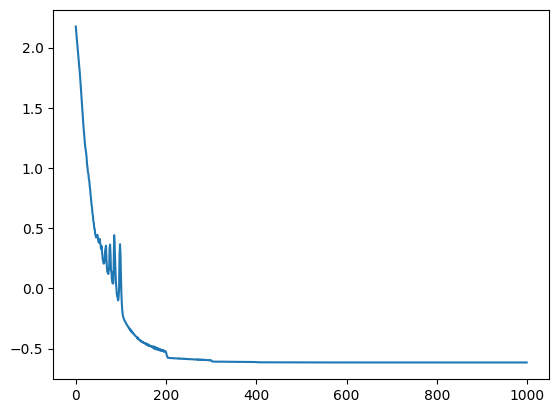

In [187]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

loss_fn(out_1, train_y1.reshape(-1,1))
loss_fn(out_2, train_y2.reshape(-1,1))
loss_fn(out_3, train_y3.reshape(-1,1))

In [188]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.2094e-01, -1.4906e-01, -2.2139e-01, -1.2911e-01, -1.8206e-01,
         -2.3899e-01, -1.2731e-01, -1.1568e-01, -1.6195e-01, -1.3038e-01,
          9.9578e-08, -1.3600e-02, -1.3611e-07,  1.7348e-04,  9.9803e-09,
         -1.0188e-07,  2.4275e-08,  2.3416e-08,  1.3521e-07, -4.1091e-10,
         -5.7308e-08,  3.8326e-08,  4.3772e-08,  8.6275e-08, -6.9429e-08,
         -6.0779e-08, -1.6159e-07, -4.7195e-08, -9.2922e-08,  6.5176e-08,
         -2.8841e-08,  1.4768e-07, -1.5397e-07,  1.0057e-07,  1.3288e-07,
         -4.0178e-08, -2.6580e-08, -9.7866e-08,  1.3829e-07,  7.7121e-09,
          1.2033e-07, -1.5695e-07, -1.5429e-08,  1.0159e-08,  5.4843e-08,
          1.3763e-07,  1.0279e-08,  7.6897e-08,  6.4240e-08,  1.1182e-08,
          4.0881e-08,  1.5438e-07,  1.3711e-07, -1.1081e-07,  5.8946e-09,
          3.7873e-08, -6.5617e-08,  7.3678e-08,  3.1586e-08, -1.4612e-07,
         -1.2725e-07, -3.7638e-08, -6.4388e-08,  5.0565e-08,  1.2320e-07,
          1.3638e-07,  1.1569e-07, -1.

tensor([[-1.2094e-01, -1.4906e-01, -2.2139e-01, -1.2911e-01, -1.8206e-01,
         -2.3899e-01, -1.2731e-01, -1.1568e-01, -1.6195e-01, -1.3038e-01,
          9.9578e-08, -1.3600e-02, -1.3611e-07,  1.7348e-04,  9.9803e-09,
         -1.0188e-07,  2.4275e-08,  2.3416e-08,  1.3521e-07, -4.1091e-10,
         -5.7308e-08,  3.8326e-08,  4.3772e-08,  8.6275e-08, -6.9429e-08,
         -6.0779e-08, -1.6159e-07, -4.7195e-08, -9.2922e-08,  6.5176e-08,
         -2.8841e-08,  1.4768e-07, -1.5397e-07,  1.0057e-07,  1.3288e-07,
         -4.0178e-08, -2.6580e-08, -9.7866e-08,  1.3829e-07,  7.7121e-09,
          1.2033e-07, -1.5695e-07, -1.5429e-08,  1.0159e-08,  5.4843e-08,
          1.3763e-07,  1.0279e-08,  7.6897e-08,  6.4240e-08,  1.1182e-08,
          4.0881e-08,  1.5438e-07,  1.3711e-07, -1.1081e-07,  5.8946e-09,
          3.7873e-08, -6.5617e-08,  7.3678e-08,  3.1586e-08, -1.4612e-07,
         -1.2725e-07, -3.7638e-08, -6.4388e-08,  5.0565e-08,  1.2320e-07,
          1.3638e-07,  1.1569e-07, -1.

tensor([[-1.5277e-01, -1.9638e-01, -2.7472e-01, -1.7119e-01,  1.9879e-01,
         -3.3809e-01, -1.6370e-01, -1.5341e-01, -1.6914e-01, -1.9191e-01,
         -1.0965e-08,  2.1211e-04, -1.0753e-10,  1.7239e-02, -1.1370e-10,
          8.3131e-10,  1.7776e-08,  2.9250e-08,  7.6111e-09,  1.0564e-09,
         -1.2745e-10,  5.7901e-09, -1.2334e-08, -7.8166e-09,  5.6599e-08,
          7.5229e-10,  1.0942e-08, -3.0007e-08, -5.8548e-09,  5.3269e-09,
          2.8282e-08,  4.5616e-09,  9.7519e-10, -2.8364e-09, -1.6844e-08,
          3.8172e-09,  5.4597e-09,  3.9088e-09,  8.1394e-09, -2.3794e-09,
          6.2956e-10,  6.1522e-10,  7.5570e-10,  1.2098e-09,  1.2490e-08,
          3.2458e-09,  1.9652e-08, -6.4865e-09,  1.3019e-08, -4.2895e-09,
         -9.7451e-10,  8.6019e-09, -2.4969e-09,  2.6828e-09,  9.9654e-10,
         -1.1239e-08,  4.2730e-08,  4.5266e-08,  3.1553e-09, -1.2888e-09,
         -5.1670e-09, -4.5495e-09, -7.7176e-08, -1.0429e-08,  1.3832e-08,
         -2.7481e-09,  9.1459e-10,  4.

In [189]:

model_1(test_x1)[0].squeeze()
test_y1.squeeze()
model_2(test_x2)[0].squeeze()
test_y2.squeeze()
model_3(test_x3)[0].squeeze()
test_y3.squeeze()


tensor([9.8295e-01, 9.8472e-01, 1.2817e-01, 6.5950e-01, 1.6966e-03, 9.8384e-01,
        9.0348e-01, 5.4309e-02, 9.7924e-01, 9.1793e-01, 1.9775e-05, 9.7962e-01,
        9.9043e-01, 2.0371e-02, 5.3384e-01, 9.6114e-01, 8.1001e-02, 8.7701e-01,
        1.3621e-02, 1.6431e-02, 3.4768e-03, 9.6448e-01, 9.6866e-01, 5.1540e-01,
        7.9976e-01, 3.7205e-01, 2.5453e-01, 3.3700e-02, 5.2857e-01, 2.8693e-01,
        1.3370e-01, 1.2339e-01, 4.5375e-04, 3.9736e-01, 1.5398e-01, 5.9708e-01,
        9.2457e-01, 9.5895e-01, 2.5082e-01, 9.8416e-04],
       grad_fn=<SqueezeBackward0>)

tensor([1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
        0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
        1., 1., 1., 0.])

tensor([2.5996e-03, 9.9991e-01, 9.9373e-01, 9.8606e-01, 8.3024e-01, 9.9924e-01,
        9.9227e-01, 9.9881e-01, 1.5155e-02, 8.0957e-05, 1.0158e-01, 9.9443e-01,
        2.5979e-04, 9.8000e-01, 1.9061e-01, 9.6626e-01, 9.8951e-01, 9.9440e-01,
        4.0778e-02, 9.9869e-01, 9.9513e-01, 3.4051e-01, 1.4892e-02, 6.9904e-04,
        9.5903e-01, 2.3410e-04, 7.9314e-01, 2.2540e-02, 9.1754e-02, 9.9993e-02,
        9.9344e-01, 9.9486e-01, 7.7208e-01, 5.2462e-01, 9.9947e-01, 9.9632e-01,
        9.9918e-01, 5.7947e-03, 9.9937e-01, 9.8379e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1.])

tensor([4.1921e-01, 9.8874e-01, 9.8448e-01, 9.8487e-01, 3.9797e-03, 1.7068e-01,
        8.1461e-01, 1.2865e-01, 9.8143e-01, 9.7202e-01, 9.4645e-01, 9.8817e-02,
        9.9309e-01, 5.6267e-01, 9.9036e-01, 1.4086e-01, 9.9145e-01, 9.7558e-01,
        9.7739e-01, 9.9083e-01, 8.2430e-01, 5.5032e-01, 9.0539e-01, 9.5031e-01,
        7.5515e-02, 7.3663e-03, 1.7834e-03, 9.8341e-01, 5.7120e-01, 9.8320e-01,
        8.0500e-01, 4.5966e-04, 9.2950e-01, 9.5558e-01, 4.0069e-03, 3.2580e-02,
        3.3133e-01, 8.9296e-01, 5.5270e-01, 3.8667e-02],
       grad_fn=<SqueezeBackward0>)

tensor([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0.])

In [190]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[42,  9],
       [ 7, 62]])

0.8985507246376812

0.8235294117647058

0.8666666666666667

0.8732394366197183

0.8857142857142857

In [112]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[18,  0],
       [ 3, 19]])

0.8636363636363636

1.0

array([[11,  4],
       [ 4, 21]])

0.84

0.7333333333333333

array([[14,  4],
       [ 0, 22]])

1.0

0.7777777777777778

In [113]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.13696769e-01, -1.42620891e-01, -1.97340474e-01,
        -1.17344126e-01, -1.69244900e-01, -1.99606642e-01,
        -1.19549260e-01, -1.09455071e-01, -1.51592359e-01,
        -1.10931925e-01, -1.74172351e-06, -3.38956379e-05,
         1.54872978e-05,  3.56450863e-03, -2.69661286e-05,
         7.80073492e-07, -8.77641287e-06,  9.20676757e-06,
        -3.10165997e-05, -3.15436482e-05, -2.23802836e-05,
        -7.41857002e-06,  3.12429802e-05, -8.22447419e-06,
         1.40214497e-05,  7.11331359e-06, -5.45090688e-06,
        -1.36915814e-05,  2.16519529e-05, -2.61826481e-05,
        -6.94631808e-06, -5.79533025e-06, -3.41568557e-05,
        -2.46595155e-05,  1.67870512e-05, -3.13767596e-05,
        -1.37230363e-05, -2.71022745e-05,  2.88616011e-05,
         9.18192654e-06,  2.74912509e-05,  9.96808467e-07,
        -2.09832742e-05, -3.03408906e-05, -2.61035780e-06,
        -1.57710947e-05,  1.90920528e-05,  4.74284980e-06,
        -1.66484479e-05,  2.84503531e-05,  2.97529937e-0

array([[-1.13696769e-01, -1.42620891e-01, -1.97340474e-01,
        -1.17344126e-01, -1.69244900e-01, -1.99606642e-01,
        -1.19549260e-01, -1.09455071e-01, -1.51592359e-01,
        -1.10931925e-01, -1.74172351e-06, -3.38956379e-05,
         1.54872978e-05,  3.56450863e-03, -2.69661286e-05,
         7.80073492e-07, -8.77641287e-06,  9.20676757e-06,
        -3.10165997e-05, -3.15436482e-05, -2.23802836e-05,
        -7.41857002e-06,  3.12429802e-05, -8.22447419e-06,
         1.40214497e-05,  7.11331359e-06, -5.45090688e-06,
        -1.36915814e-05,  2.16519529e-05, -2.61826481e-05,
        -6.94631808e-06, -5.79533025e-06, -3.41568557e-05,
        -2.46595155e-05,  1.67870512e-05, -3.13767596e-05,
        -1.37230363e-05, -2.71022745e-05,  2.88616011e-05,
         9.18192654e-06,  2.74912509e-05,  9.96808467e-07,
        -2.09832742e-05, -3.03408906e-05, -2.61035780e-06,
        -1.57710947e-05,  1.90920528e-05,  4.74284980e-06,
        -1.66484479e-05,  2.84503531e-05,  2.97529937e-0

array([[-1.5793009e-01, -1.7742166e-01, -2.3626013e-01, -1.7123283e-01,
         1.6444136e-01, -2.8431591e-01, -1.5325227e-01, -1.3154776e-01,
        -1.6661048e-01, -1.7492115e-01, -6.5357119e-07,  1.4196394e-06,
         7.3462240e-07,  1.4896766e-02,  1.6672626e-06, -7.0232034e-08,
         5.0272301e-06,  6.5367517e-06,  1.2329717e-05, -5.7932916e-06,
         6.1475816e-09,  2.0571035e-06,  1.3451410e-06, -2.7281774e-06,
         9.6626527e-06, -3.7038742e-08, -1.3667778e-06, -5.0661079e-06,
         2.8880092e-06, -2.5448134e-07, -2.1007650e-06,  1.2684629e-07,
        -3.8562121e-06, -6.9208774e-08,  8.1721028e-06,  2.2821612e-06,
         1.9762915e-06,  6.2327381e-06,  3.5580754e-07, -2.8982761e-06,
        -5.1259167e-06, -3.4341323e-07,  6.3227565e-09, -3.2053091e-10,
         1.1025406e-06, -5.1311449e-06,  1.5473446e-06, -4.8498555e-07,
         3.2378896e-06,  8.0655045e-06, -3.8990197e-07,  1.9768760e-07,
        -3.7172438e-06,  1.5863528e-06,  6.3308107e-07,  6.57028

In [114]:
threshold=0.15
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.11369677, -0.14262089, -0.19734047, -0.11734413, -0.1692449 ,
        -0.19960664, -0.11954926, -0.10945507, -0.15159236, -0.11093193,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

10